In [119]:
import pandas as pd
import torch
from torch import nn
from torchmetrics.classification import BinaryAccuracy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [120]:
# Load raw data
df = pd.read_csv("../azureml/data/lending_club.csv", delimiter=",")

# Create binary label
if "loan_status" in df:
    print("loan_status column exists, create binary label loan_repaid")
    df["loan_repaid"] = np.where(df["loan_status"] == "Fully Paid", 1, 0)
    df = df.drop(labels="loan_status", axis=1)
else:
    print("loan_status column does not exist, ignore")

# Drop features
df = df.drop(labels=["grade", "issue_d"], axis=1)

# Fill-in mort acc
mortmeans = df.groupby(by="total_acc")["mort_acc"].mean()


def myfill(total, mort):
    if pd.isna(mort):
        return mortmeans[total]
    else:
        return mort


df["mort_acc"] = df.apply(lambda x: myfill(x.total_acc, x.mort_acc), axis=1)

# Keep top 30 most frequent values for emp_title
top_values = (
    df["emp_title"]
    .groupby(df["emp_title"])
    .count()
    .sort_values(ascending=False)
    .head(30)
    .index.tolist()
)
df["emp_title"] = df["emp_title"].apply(lambda x: "Other" if x not in top_values else x)

# Keep top 30 most frequent values for title
top_values = (
    df["title"]
    .groupby(df["title"])
    .count()
    .sort_values(ascending=False)
    .head(30)
    .index.tolist()
)
df["title"] = df["title"].apply(lambda x: "Other" if x not in top_values else x)

# Drop rows with missing data
df = df.dropna()


# Convert term feature to number
def convert_term(x):
    if x == " 36 months":
        return 36
    if x == " 60 months":
        return 60


df["term"] = df["term"].apply(lambda x: convert_term(x))


# Home ownership feature - join categories
def homeownership(x):
    if (x == "NONE") or (x == "ANY"):
        return "OTHER"
    else:
        return x


df["home_ownership"].apply(lambda x: homeownership(x)).unique()

# Parse zip and create dummy vars
df["address"] = df["address"].str[-5:]

# Parse year
df["earliest_cr_year"] = pd.to_numeric(df["earliest_cr_line"].str[-4:])
df = df.drop(labels="earliest_cr_line", axis=1)

# Get dummies (OHE)
df = pd.get_dummies(
    columns=[
        "sub_grade",
        "verification_status",
        "application_type",
        "initial_list_status",
        "purpose",
        "home_ownership",
        "address",
        "emp_title",
        "title",
        "emp_length",
    ],
    data=df,
    drop_first=True,
)

loan_status column exists, create binary label loan_repaid


In [121]:
# Train test split
X = df.drop(labels="loan_repaid", axis=1)
y = df["loan_repaid"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [117]:
# Scale (note this is just for debug, we should first split test and train and fit just to train)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [118]:
# Create tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.from_numpy(y_train.to_numpy(dtype=np.float32)).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.from_numpy(y_test.to_numpy(dtype=np.float32)).reshape(-1, 1)

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [102]:
# Define model - not used in my example as I used nn.Sequential
# Leaving here for my reference should I need to use custom definition in a future
class LandingClub(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(149, 75)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(75, 37)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(37, 18)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(18, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [103]:
# model = LandingClub().to("cpu")
model = nn.Sequential(
    nn.Linear(149, 75),
    nn.LayerNorm(75),
    nn.ReLU(),
    nn.Linear(75, 37),
    nn.ReLU(),
    nn.Linear(37, 18),
    nn.ReLU(),
    nn.Linear(18, 1),
    nn.Sigmoid(),
)
print(model)

Sequential(
  (0): Linear(in_features=149, out_features=75, bias=True)
  (1): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
  (2): ReLU()
  (3): Linear(in_features=75, out_features=37, bias=True)
  (4): ReLU()
  (5): Linear(in_features=37, out_features=18, bias=True)
  (6): ReLU()
  (7): Linear(in_features=18, out_features=1, bias=True)
  (8): Sigmoid()
)


In [104]:
# Define loss function
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train model
epochs = 2000
batch_size = 1000
losses = []
losses_val = []
accuracies = []
accuracies_val = []
measure_accuracy = BinaryAccuracy()
best_val_accuracy = 0.0
early_stop_patience = 5
early_stop_counter = 0

# Create dataset and loader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Train
for epoch in range(epochs):
    # Iterate over the data in batches
    for X_batch, y_batch in train_loader:
        # Forward pass - get predictions for train
        y_train_pred = model.forward(X_batch)

        # Calculate loss
        loss = loss_function(y_train_pred, y_batch)

        # Calculate other metrics
        accuracy = measure_accuracy(y_train_pred, y_batch)

        # Save metrics and print
        losses.append(loss)
        accuracies.append(accuracy)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate validation loss and accuracy
    with torch.no_grad():
        y_test_pred = model.forward(X_test)
        val_loss = loss_function(y_test_pred, y_test)
        val_accuracy = measure_accuracy(y_test_pred, y_test)

    # Early stopping
    if val_accuracy >= best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
        best_model = model.state_dict()
    else:
        early_stop_counter += 1

    # Save metrics and print
    losses_val.append(val_loss)
    accuracies_val.append(val_accuracy)
    print(
        f"epoch: {epoch}  loss: {losses[-1].item():10.8f} val_loss: {val_loss.item():10.8f} accuracy: {accuracies[-1].item():10.8f} val_accuracy: {val_accuracy.item():10.8f}"
    )

    # Check early stopping
    if early_stop_counter >= early_stop_patience:
        print(
            f"Early stopping at epoch {epoch}, best validation accuracy: {best_val_accuracy}"
        )
        break

epoch: 0  loss: 0.24463199 val_loss: 0.25630641 accuracy: 0.89134437 val_accuracy: 0.89119995
epoch: 1  loss: 0.28460422 val_loss: 0.25336888 accuracy: 0.87292820 val_accuracy: 0.89134586
epoch: 2  loss: 0.26386765 val_loss: 0.25301787 accuracy: 0.89871085 val_accuracy: 0.89203566
epoch: 3  loss: 0.26307720 val_loss: 0.25300688 accuracy: 0.88029468 val_accuracy: 0.89165097
epoch: 4  loss: 0.20991144 val_loss: 0.25466979 accuracy: 0.92265195 val_accuracy: 0.89137238
epoch: 5  loss: 0.20733829 val_loss: 0.25287566 accuracy: 0.91528547 val_accuracy: 0.89236730
epoch: 6  loss: 0.28270820 val_loss: 0.25280213 accuracy: 0.87476981 val_accuracy: 0.89192951
epoch: 7  loss: 0.25123087 val_loss: 0.25244296 accuracy: 0.89502764 val_accuracy: 0.89227444
epoch: 8  loss: 0.26436067 val_loss: 0.25419918 accuracy: 0.88029468 val_accuracy: 0.89187646
epoch: 9  loss: 0.28372326 val_loss: 0.25311905 accuracy: 0.87292820 val_accuracy: 0.89178360
epoch: 10  loss: 0.24838094 val_loss: 0.25329107 accuracy: 0

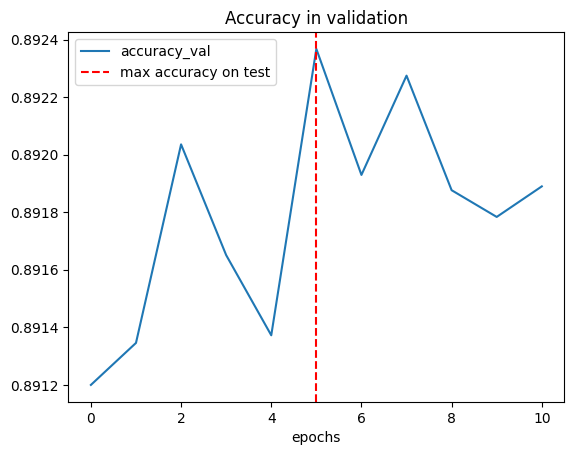

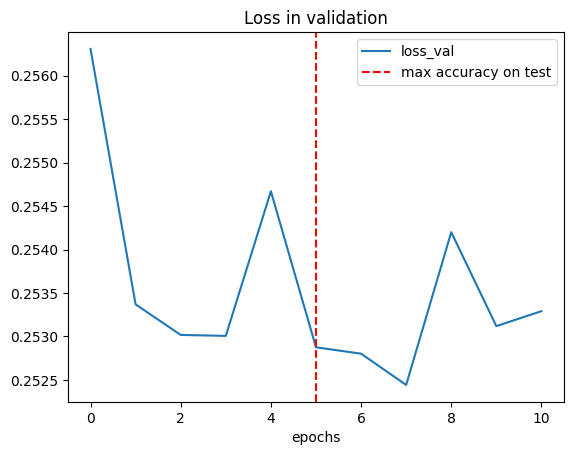

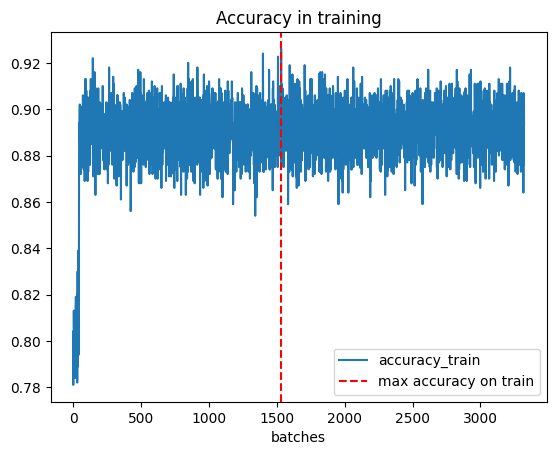

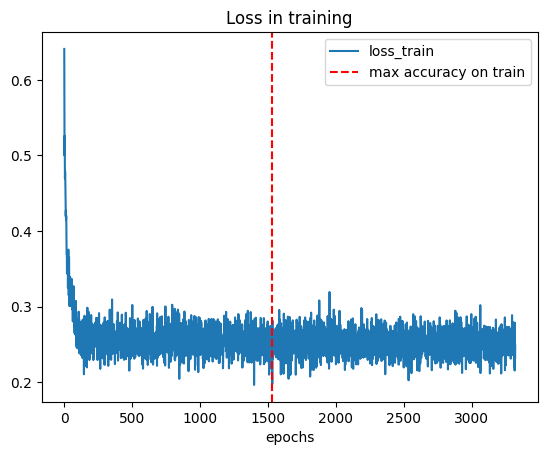

In [105]:
plt.plot(accuracies_val, label="accuracy_val")
plt.axvline(
    x=accuracies_val.index(max(accuracies_val)),
    color="r",
    linestyle="--",
    label="max accuracy on test",
)
plt.title("Accuracy in validation")
plt.xlabel("epochs")
plt.legend()
plt.show()

plt.plot(np.array([x.item() for x in losses_val]), label="loss_val")
plt.axvline(
    x=accuracies_val.index(max(accuracies_val)),
    color="r",
    linestyle="--",
    label="max accuracy on test",
)
plt.title("Loss in validation")
plt.xlabel("epochs")
plt.legend()
plt.show()

plt.plot(accuracies, label="accuracy_train")
plt.axvline(
    x=accuracies.index(max(accuracies)),
    color="r",
    linestyle="--",
    label="max accuracy on train",
)
plt.xlabel("batches")
plt.title("Accuracy in training")
plt.legend()
plt.show()

plt.plot(np.array([x.item() for x in losses]), label="loss_train")
plt.axvline(
    x=accuracies.index(max(accuracies)),
    color="r",
    linestyle="--",
    label="max accuracy on train",
)
plt.xlabel("batches")
plt.title("Loss in training")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [106]:
# Save model where accuracies_val is max
torch.save(best_model, "lending_club_pytorch.pt")